In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras import layers
import matplotlib.pyplot as plt

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_8288\3157261273.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Verover de data. Het is een dataset van IMDB met filmrecensies. De labels zijn binair en geven aan of een film wel of geen aanrader is volgens de reviews.

In [2]:
from keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=10000,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=42,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

bekijk de geimporteerde data.

In [3]:
X_train[0:10]

array([list([1, 11, 4079, 11, 4, 1986, 745, 3304, 299, 1206, 590, 3029, 1042, 37, 47, 27, 1269, 2, 7637, 19, 6, 3586, 15, 1367, 3196, 17, 1002, 723, 1768, 2887, 757, 46, 4, 232, 1131, 39, 107, 3589, 11, 4, 4539, 198, 24, 4, 1834, 133, 4, 107, 7, 98, 413, 8911, 5835, 11, 35, 781, 8, 169, 4, 2179, 5, 259, 334, 3773, 8, 4, 3497, 10, 10, 17, 16, 3381, 46, 34, 101, 612, 7, 84, 18, 49, 282, 167, 2, 7173, 122, 24, 1414, 8, 177, 4, 392, 531, 19, 259, 15, 934, 40, 507, 39, 2, 260, 77, 8, 162, 5097, 121, 4, 65, 304, 273, 13, 70, 1276, 2, 8, 15, 745, 3304, 5, 27, 322, 2197, 2, 2, 70, 30, 2, 88, 17, 6, 3029, 1042, 29, 100, 30, 4943, 50, 21, 18, 148, 15, 26, 5980, 12, 152, 157, 10, 10, 21, 19, 3196, 46, 50, 5, 4, 1636, 112, 828, 6, 1003, 4, 162, 5097, 2, 517, 6, 2, 7, 4, 9527, 5593, 4, 351, 232, 385, 125, 6, 1693, 39, 2383, 5, 29, 69, 5593, 5670, 6, 162, 5097, 1567, 232, 256, 34, 718, 5612, 2980, 8, 6, 226, 762, 7, 2, 7830, 5, 517, 2, 6, 3242, 7, 4, 351, 232, 37, 9, 1861, 8, 123, 3196, 2, 5612, 188

Zoals je kunt zien bevat `X_train` vectoren met getallen. Elke vector staat voor een review. Elk getal staat voor een woord.

Met onderstaande code kun je een vector met getallen terugvertalen naar woorden. Run deze code.

In [4]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

1641221/1641221 [==============================] - 1s 0us/step


"? in panic in the streets richard widmark plays u s navy doctor who has his week ? interrupted with a corpse that contains plague as cop paul douglas properly points out the guy died from two bullets in the chest that's not the issue here the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease br br as was pointed out by any number of people for some reason director ? kazan did not bother to cast the small parts with anyone that sounds like they're from ? having been to new orleans where the story takes place i can personally ? to that richard widmark and his wife barbara ? ? can be ? because as a navy doctor he could be assigned there but for those that are natives it doesn't work br br but with plague out there and the news being kept a secret the new orleans ? starts a ? of the city's underworld the dead guy came off a ship from europe and he had underworld connections a new orleans wise guy played by jack palance jumps to a

In de tekst zie je een aantal vraagtekens. Een vraagteken staat in dit geval voor 'onbekend woord'.

De input is in deze vorm lastig te verwerken voor een neuraal netwerk. De getallen zijn categorische labels. Daarom gebruiken we One-hot-encoding. Helaas kan de `OneHotEncoder` uit sklearn niet overweg met deze input. Daarom maken we de input handmatig geschikt voor het neurale netwerk.

In [5]:
def vectorize_sequences(sequences, dimension=10000):
    # Maak een matrix van de vorm (len(sequences), dimension) met nullen
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # zet de juiste waarden in results[i] op 1
    return results

In [6]:
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

Controleer of het omzetten van de data goed gegaan is

In [7]:
X_train[0:5]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

Maak een neuraal netwerk dat met deze data overweg kan.

In [8]:
# Model IMDB
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) # 10000 is the size of the input because we have 10000 words
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # sigmoid because we want to predict a binary output


Kies een loss function en optimizer en compileer het netwerk. Bedenk hierbij goed welke het meest geschikt is voor het probleem dat je aan het oplossen bent en voor de vorm van de output.

In [9]:
from keras.optimizers.legacy import Adam
# Compile the model
model.compile(Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        


                                                                 
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Split in train en validatieset

In [10]:
# Al gedaan??

Train je model model met de gemaakte train- en validatieset. 

In [11]:
# Train the model
# model.fit(X_train, y_train, epochs=4, batch_size=512)

Plot een learning curve. Zet de accuraatheid uit tegen de epochs en maak onderscheid tussen de training en validatie data. Wat zou volgens dit figuur het optimale aantal epochs zijn?

In [12]:
# Saving each epoch in the history variable
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plotting the training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50


782/782 [==============================] - 10s 12ms/step - loss: 0.3182 - accuracy: 0.8655 - val_loss: 0.2900 - val_accuracy: 0.8772
Epoch 2/50
782/782 [==============================] - 3s 3ms/step - loss: 0.1798 - accuracy: 0.9280 - val_loss: 0.3307 - val_accuracy: 0.8724
Epoch 3/50
782/782 [==============================] - 3s 3ms/step - loss: 0.1252 - accuracy: 0.9479 - val_loss: 0.3919 - val_accuracy: 0.8616
Epoch 4/50
770/782 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9637

KeyboardInterrupt: 

Rond 10 epochs heeft het model een validation accuract van ±86% en een ±99% accuracy op de train data. Uit dit figuur blijkt dat de beste hoeveelheid epochs te zijn. Hoeweel de validatie accuracy hoger is met 1 epoch, vertrouw ik het niet helemaal. Met meer epochs gaat de accuracy steeds omlaag en de accuracy omhoog, dus dat betekend dat er overfitting is.

Plot een foutcurve. Zet de loss uit tegen de epochs en maak onderscheid tussen de training en validatie data. Bekijk of er misschien sprake is van overfitting/underfitting.

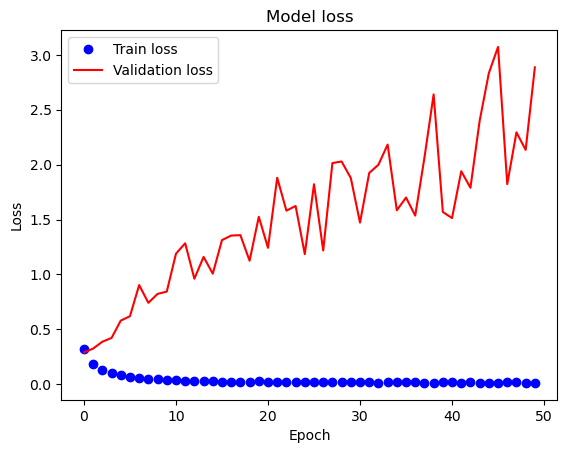

In [ ]:
# Plotting the loss curve
plt.plot(history.history['loss'], 'bo')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

Weer kan je hier zien dat er spraken is van overfitting. Het model leert te veel aan de train data te goed, tot op het punt dat het de ruis en outliers in de trainingsdata begint te leren in plaats van de daadwerkelijke onderliggende patronen. Als gevolg hiervan presteert het model zeer goed op de trainingsdata (vandaar de dalende trainingsloss), maar niet goed op nieuwe, ongeziene data (vandaar de stijgende validatieloss).

Test je model

In [ ]:
# New Model with lower complexity
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
782/782 [==============================] - 3s 4ms/step - loss: 0.3698 - accuracy: 0.8476 - val_loss: 0.3085 - val_accuracy: 0.8748
Epoch 2/50
782/782 [==============================] - 1s 1ms/step - loss: 0.2159 - accuracy: 0.9191 - val_loss: 0.3212 - val_accuracy: 0.8711
Epoch 3/50
782/782 [==============================] - 1s 1ms/step - loss: 0.1686 - accuracy: 0.9390 - val_loss: 0.3913 - val_accuracy: 0.8641
Epoch 4/50
782/782 [==============================] - 1s 1ms/step - loss: 0.1400 - accuracy: 0.9506 - val_loss: 0.4148 - val_accuracy: 0.8608
Epoch 5/50
782/782 [==============================] - 1s 1ms/step - loss: 0.1215 - accuracy: 0.9575 - val_loss: 0.4758 - val_accuracy: 0.8560
Epoch 6/50
782/782 [==============================] - 3s 3ms/step - loss: 0.1050 - accuracy: 0.9657 - val_loss: 0.5295 - val_accuracy: 0.8538
Epoch 7/50
782/782 [==============================] - 1s 2ms/step - loss: 0.0957 - accuracy: 0.9702 - val_loss: 0.5781 - val_accuracy: 0.8530
Epoch 

Kijk wat er gebeurt met de foutcurves van de train en validatiedata en met de testscore als je verschillende netwerken maakt met verschillende instellingen (aantal lagen, aantal neuronen, optimizer).

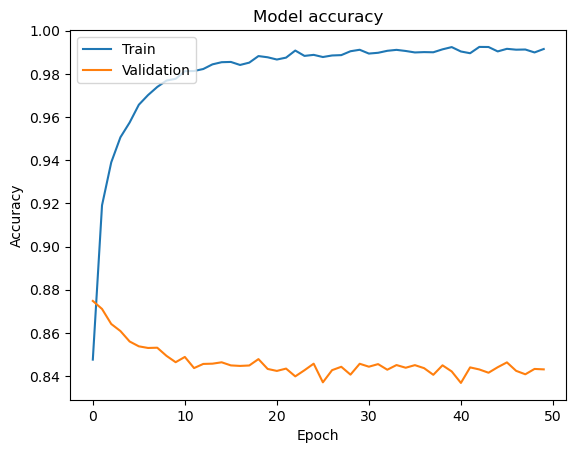

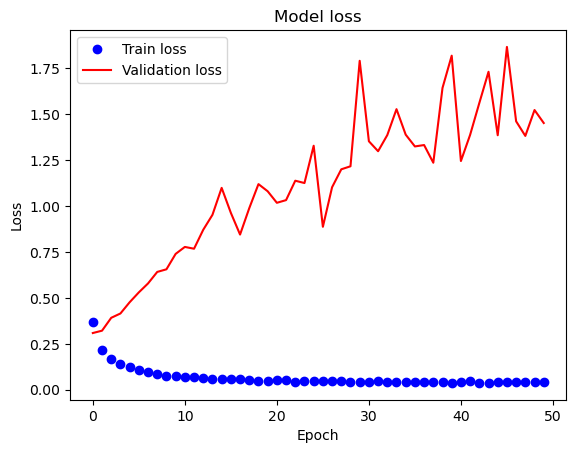

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss curve
plt.plot(history.history['loss'], 'bo')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()


Hier kan je alsnog zien dat er spraken is van overfitting. Ookal is de complexiteit van het model omlaag gehaald. Het model went te erg aan de train data en kan niet goed presteren op de test data. Dit kan je zien door te kijken naar de loss grafiek, daarin zie je dat je training loss kleiner wordt, maar de validatie loss groter, dus hij presteert beter op de training set. Wat logisch is, omdat er spraken is van overfitting

Bonusvraag: Zoek uit wat dropout lagen voor deep learning zijn en experimenteer met dropout lagen in jouw netwerk. Welke effect heeft dit op de resultaten?

In [ ]:
from keras import regularizers
# New model with use of dropout
model = models.Sequential()
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.5)) # This means it drops 50% of the neurons
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
782/782 [==============================] - 3s 4ms/step - loss: 0.6880 - accuracy: 0.5079 - val_loss: 0.6037 - val_accuracy: 0.7928
Epoch 2/50
782/782 [==============================] - 1s 1ms/step - loss: 0.6488 - accuracy: 0.5765 - val_loss: 0.5559 - val_accuracy: 0.8383
Epoch 3/50
782/782 [==============================] - 1s 1ms/step - loss: 0.6335 - accuracy: 0.5940 - val_loss: 0.5931 - val_accuracy: 0.8592
Epoch 4/50
782/782 [==============================] - 1s 1ms/step - loss: 0.6292 - accuracy: 0.5902 - val_loss: 0.5185 - val_accuracy: 0.8498
Epoch 5/50
782/782 [==============================] - 1s 1ms/step - loss: 0.6211 - accuracy: 0.6144 - val_loss: 0.4599 - val_accuracy: 0.8634
Epoch 6/50
782/782 [==============================] - 1s 1ms/step - loss: 0.5802 - accuracy: 0.6478 - val_loss: 0.4498 - val_accuracy: 0.8456
Epoch 7/50
782/782 [==============================] - 1s 1ms/step - loss: 0.5367 - accuracy: 0.6933 - val_loss: 0.3883 - val_accuracy: 0.8460
Epoch 

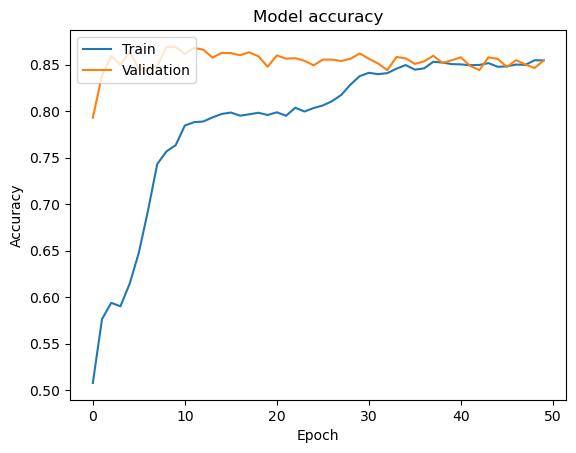

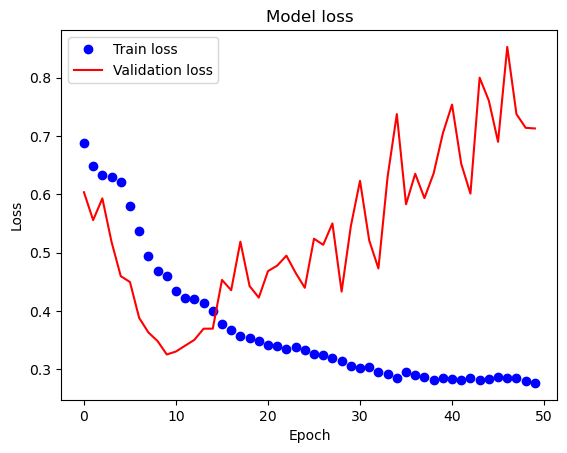

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss curve
plt.plot(history.history['loss'], 'bo')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

Hier gebruik ik `Dropout(0.5)`, dit betekend dat 50% van de neuronen worden uitgeschaeld bij elke trainings ronde. Dit betekent dat hun bijdrage aan de neuronen in de volgende laag en alle daaropvolgende berekeningen wordt genegeerd voor die specifieke trainingsronde.

Dit kan ervoor zorgen dat het model niet geoverfit wordt, want omdat de helft van de neuronen uitgeschakeld worden, kan het neuraal netwerk niet genoeg 'wennen' aan de test data.

# Cross validation 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from sklearn.model_selection import KFold

k = 4
num_epochs = 50
all_scores = []
history = []

# Initialize KFold cross-validator
kf = KFold(n_splits=k)

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print('processing fold #', i+1)
    
    # Split data into training and validation sets
    partial_train_data, val_data = X_train[train_index], X_train[val_index]
    partial_train_targets, val_targets = y_train[train_index], y_train[val_index]

    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizers.Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model and save history
    hist = model.fit(partial_train_data, partial_train_targets,
                     epochs=num_epochs, batch_size=32, verbose=0,
                     validation_data=(val_data, val_targets))
    
    history.append(hist)
    
    # Evaluate the model on validation data
    _, val_accuracy = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_accuracy)

print('All validation accuracies:', all_scores)
print('Mean validation accuracy:', np.mean(all_scores))


processing fold # 1


processing fold # 2


processing fold # 3


processing fold # 4


All validation accuracies: [0.8780800104141235, 0.876479983329773, 0.8622400164604187, 0.8681600093841553]
Mean validation accuracy: 0.8712400048971176


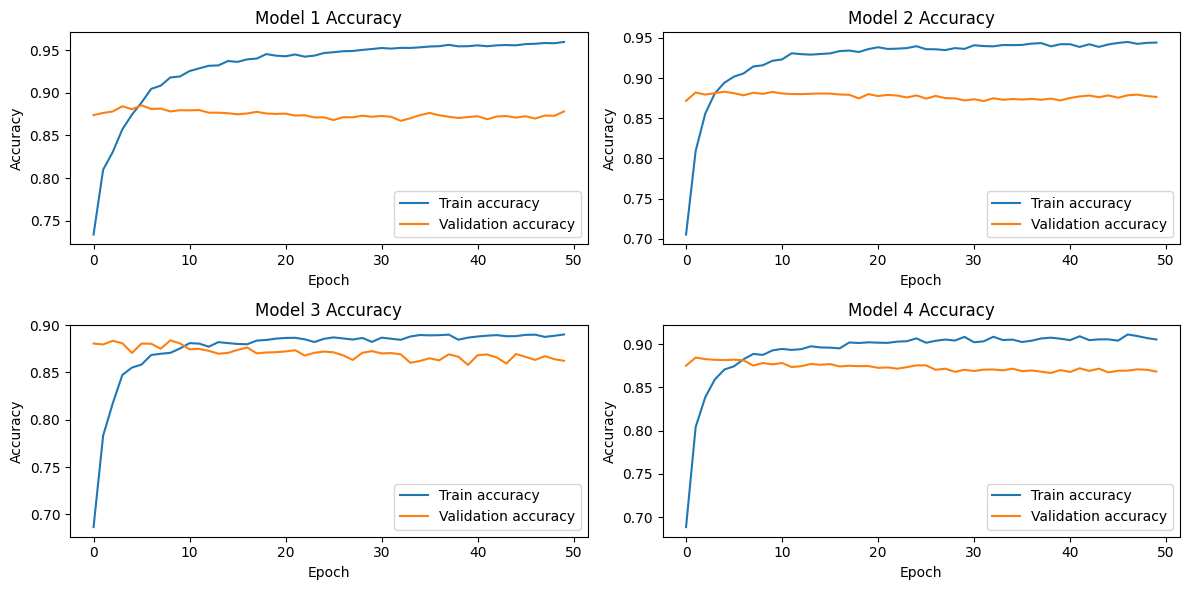

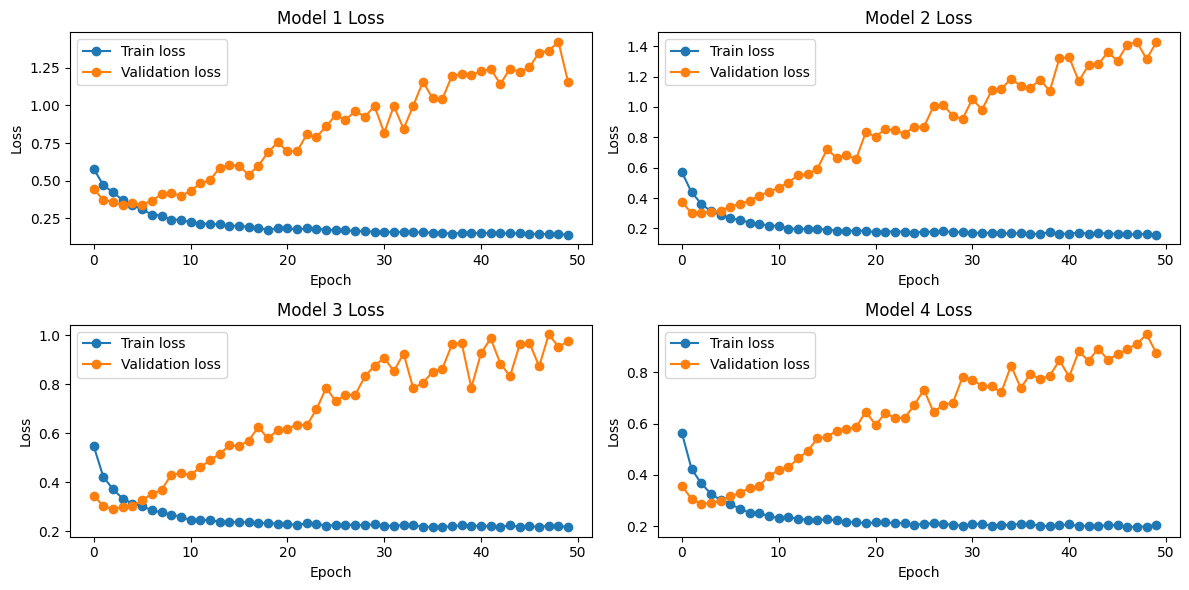

In [21]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

for i in range(k):
    plt.subplot(2, 2, i+1)  # Creating subplots for each fold
    plt.plot(history[i].history['accuracy'], label='Train accuracy')
    plt.plot(history[i].history['val_accuracy'], label='Validation accuracy')
    plt.title(f'Model {i+1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

for i in range(k):
    plt.subplot(2, 2, i+1)  # Creating subplots for each fold
    plt.plot(history[i].history['loss'], label='Train loss', marker='o')
    plt.plot(history[i].history['val_loss'], label='Validation loss', marker='o')
    plt.title(f'Model {i+1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Print all validation accuracies
for i, acc in enumerate(all_scores):
    print(f'Model {i+1} validation accuracy:', acc)

# Print mean validation accuracy
print('Mean validation accuracy:', np.mean(all_scores))

Model 1 validation accuracy: 0.8780800104141235
Model 2 validation accuracy: 0.876479983329773
Model 3 validation accuracy: 0.8622400164604187
Model 4 validation accuracy: 0.8681600093841553
Mean validation accuracy: 0.8712400048971176


### Cross-validation

Cross-validation (CV) is een methode om de prestaties van een machine learning-model te beoordelen en te verbeteren door de dataset op te splitsen in meerdere subsets (folds) en vervolgens het model te trainen en te evalueren op verschillende combinaties van deze subsets.

#### Werkwijze:

1. K-fold Cross-validation: De dataset wordt verdeeld in k subsets (vaak k=5 of k=10). Het model wordt dan k keer getraind en gevalideerd, waarbij telkens een andere fold als validatieset wordt gebruikt en de overige folds als trainingsset.

2. Voordelen:
    - Helpt overfitting te voorkomen omdat het model wordt geëvalueerd op meerdere testsets.
    - Biedt een nauwkeurigere schatting van de prestaties van het model dan een enkele train-test split.

3. Toepassing: Cross-validation wordt gebruikt om hyperparameters te tunen, modelselectie te doen tussen verschillende algoritmen, en om een betrouwbare schatting te geven van de prestaties van het uiteindelijke model.